In [3]:
!apt install unzip

!unzip -q "/content/Dataset.zip"

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
unzip is already the newest version (6.0-26ubuntu3.2).
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.


In [ ]:
!apt install git
!git clone "https://github.com/rezapace/Machine-Learning-fish-classification"

In [3]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16, ResNet50
from tensorflow.keras.layers import GlobalMaxPooling2D, Dense
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import confusion_matrix, classification_report

In [4]:
def create_data_generators(train_dir, valid_dir, test_dir, target_size=(224, 224), batch_size=32, preprocessing_function=None):
    train_datagen = ImageDataGenerator(
        rotation_range=40,
        horizontal_flip=True,
        preprocessing_function=preprocessing_function
    )
    valid_datagen = ImageDataGenerator(preprocessing_function=preprocessing_function)
    test_datagen = ImageDataGenerator()

    train_generator = train_datagen.flow_from_directory(
        train_dir, target_size=target_size, batch_size=batch_size,
        class_mode='categorical', seed=42, shuffle=True
    )
    valid_generator = valid_datagen.flow_from_directory(
        valid_dir, target_size=target_size, batch_size=batch_size,
        class_mode='categorical', seed=42, shuffle=False
    )
    test_generator = test_datagen.flow_from_directory(
        test_dir, target_size=target_size, batch_size=batch_size,
        class_mode='categorical', seed=42, shuffle=False
    )

    return train_generator, valid_generator, test_generator

# Definisikan direktori
train_dir = "/content/Dataset/Data_Train"
valid_dir = "/content/Dataset/Data_Validasi"
test_dir = "/content/Dataset/Data_Uji"

# Buat generator data
vgg16_train, vgg16_valid, vgg16_test = create_data_generators(
    train_dir, valid_dir, test_dir,
    preprocessing_function=tf.keras.applications.vgg16.preprocess_input
)
resnet50_train, resnet50_valid, resnet50_test = create_data_generators(
    train_dir, valid_dir, test_dir,
    preprocessing_function=tf.keras.applications.resnet50.preprocess_input
)


Found 340 images belonging to 2 classes.
Found 86 images belonging to 2 classes.
Found 40 images belonging to 2 classes.
Found 340 images belonging to 2 classes.
Found 86 images belonging to 2 classes.
Found 40 images belonging to 2 classes.


In [5]:
def create_model(base_model, num_classes=2):
    model = Sequential([
        base_model,
        GlobalMaxPooling2D(),
        Dense(128, activation="relu"),
        Dense(128, activation="relu"),
        Dense(num_classes, activation="softmax")
    ])
    return model

# Buat model VGG16
base_vgg16 = VGG16(include_top=False, input_shape=(224, 224, 3), weights='imagenet')
base_vgg16.trainable = False
vgg16_model = create_model(base_vgg16)

# Buat model ResNet50
base_resnet50 = ResNet50(include_top=False, input_shape=(224, 224, 3), weights='imagenet')
base_resnet50.trainable = False
resnet50_model = create_model(base_resnet50)


In [6]:
def train_model(model, train_data, valid_data, epochs=10, checkpoint_path=None):
    model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

    callbacks = []
    if checkpoint_path:
        checkpoint = ModelCheckpoint(checkpoint_path, save_best_only=True, monitor='val_loss', mode='min', verbose=1)
        callbacks.append(checkpoint)

    history = model.fit(
        train_data,
        epochs=epochs,
        validation_data=valid_data,
        callbacks=callbacks
    )
    return history

# Latih model VGG16
vgg16_history = train_model(vgg16_model, vgg16_train, vgg16_valid,
                            checkpoint_path='/content/model_vgg16_GlobalMax_aug.h5')

# Latih model ResNet50
resnet50_history = train_model(resnet50_model, resnet50_train, resnet50_valid,
                               checkpoint_path='/content/model_resnet50_GlobalMax_aug.h5')


Epoch 1/10
11/11 [==============================] - ETA: 0s - loss: 14.2503 - accuracy: 0.5824
Epoch 1: val_loss improved from inf to 3.82502, saving model to /content/model_vgg16_GlobalMax_aug.h5
11/11 [==============================] - 23s 1s/step - loss: 14.2503 - accuracy: 0.5824 - val_loss: 3.8250 - val_accuracy: 0.7442
Epoch 2/10


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


11/11 [==============================] - ETA: 0s - loss: 4.0840 - accuracy: 0.7647
Epoch 2: val_loss improved from 3.82502 to 3.46653, saving model to /content/model_vgg16_GlobalMax_aug.h5
11/11 [==============================] - 6s 594ms/step - loss: 4.0840 - accuracy: 0.7647 - val_loss: 3.4665 - val_accuracy: 0.7326
Epoch 3/10
11/11 [==============================] - ETA: 0s - loss: 2.1785 - accuracy: 0.8324
Epoch 3: val_loss improved from 3.46653 to 1.18621, saving model to /content/model_vgg16_GlobalMax_aug.h5
11/11 [==============================] - 6s 497ms/step - loss: 2.1785 - accuracy: 0.8324 - val_loss: 1.1862 - val_accuracy: 0.8837
Epoch 4/10
11/11 [==============================] - ETA: 0s - loss: 0.7962 - accuracy: 0.9000
Epoch 4: val_loss improved from 1.18621 to 0.93973, saving model to /content/model_vgg16_GlobalMax_aug.h5
11/11 [==============================] - 7s 607ms/step - loss: 0.7962 - accuracy: 0.9000 - val_loss: 0.9397 - val_accuracy: 0.9419
Epoch 5/10
11/11 [

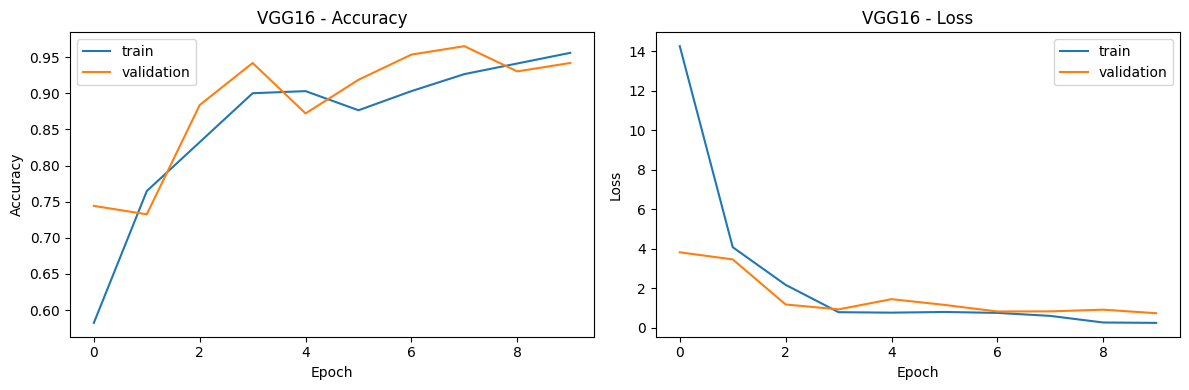

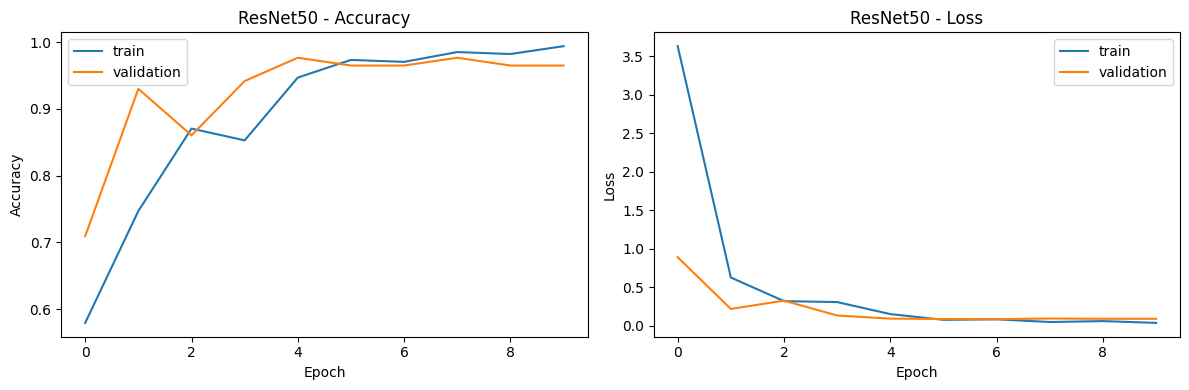

In [7]:
def plot_training_history(history, title):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='train')
    plt.plot(history.history['val_accuracy'], label='validation')
    plt.title(f'{title} - Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='validation')
    plt.title(f'{title} - Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_training_history(vgg16_history, 'VGG16')
plot_training_history(resnet50_history, 'ResNet50')


VGG16 Model Evaluation:
2/2 [==============================] - 3s 3s/step


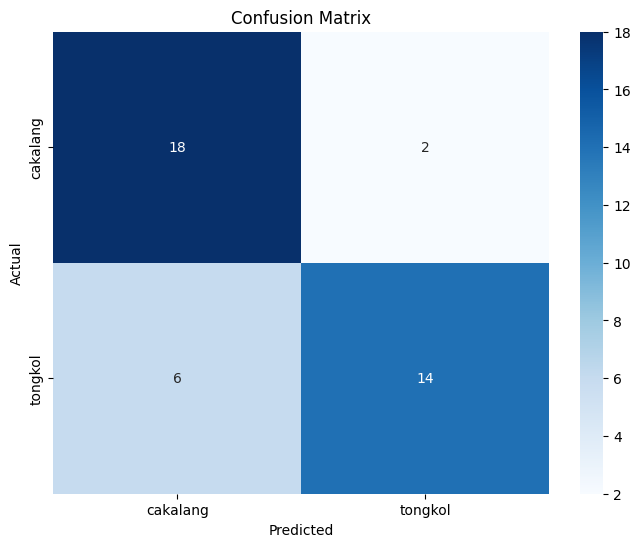

              precision    recall  f1-score   support

    cakalang       0.75      0.90      0.82        20
     tongkol       0.88      0.70      0.78        20

    accuracy                           0.80        40
   macro avg       0.81      0.80      0.80        40
weighted avg       0.81      0.80      0.80        40

ResNet50 Model Evaluation:
2/2 [==============================] - 2s 1s/step


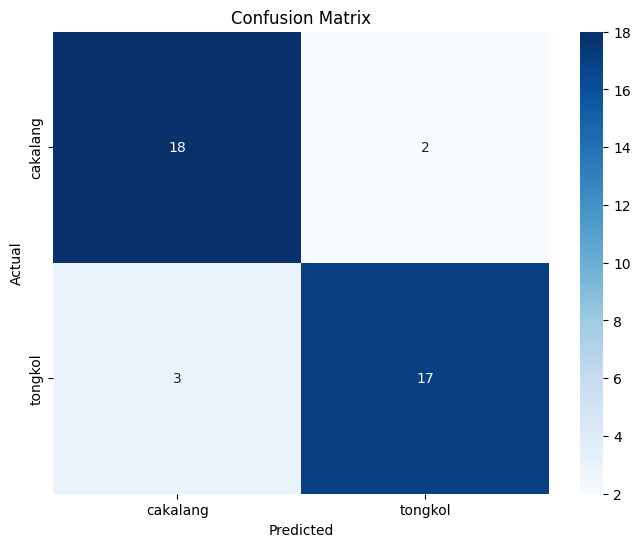

              precision    recall  f1-score   support

    cakalang       0.86      0.90      0.88        20
     tongkol       0.89      0.85      0.87        20

    accuracy                           0.88        40
   macro avg       0.88      0.88      0.87        40
weighted avg       0.88      0.88      0.87        40



In [8]:
def evaluate_model(model, test_data, class_labels):
    predictions = model.predict(test_data)
    predicted_classes = np.argmax(predictions, axis=1)
    true_classes = test_data.classes

    cm = confusion_matrix(true_classes, predicted_classes)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_labels, yticklabels=class_labels, cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

    report = classification_report(true_classes, predicted_classes, target_names=class_labels)
    print(report)

class_labels = list(vgg16_test.class_indices.keys())

print("VGG16 Model Evaluation:")
evaluate_model(vgg16_model, vgg16_test, class_labels)

print("ResNet50 Model Evaluation:")
evaluate_model(resnet50_model, resnet50_test, class_labels)


In [9]:
vgg16_model.save("/content/model_vgg16_GlobalMax_aug.h5")
resnet50_model.save("/content/model_resnet50_GlobalMax_aug.h5")


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
